# Streuung der Deadlines

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 30)

In [3]:
import utils.scheduling_solver as ssv

import utils.schedule_deadline as deadline_gen
import utils.rolling_planning.init_jobs_times as rp_init

## Generierung des Datensatzes für 17 Tage (Ankunft)

In [5]:
df_instance = pd.read_csv("data/00_instance.csv")

df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 17,  u_b_mmax = 0.96)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
3225,Job_322,5,M9,76
3226,Job_322,6,M5,47
3227,Job_322,7,M3,52
3228,Job_322,8,M4,90


In [6]:
df_times_all = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1.0)
df_times_all.rename(columns={"Deadline": "Deadline_original"}, inplace=True)
df_times_all

,Job,Arrival,Deadline_original
0,Job_000,0.00,1176
1,Job_001,82.55,1600
2,Job_002,143.24,1834
3,Job_003,194.98,2144
4,Job_004,231.20,1401
...,...,...,...
318,Job_318,24156.49,26106
319,Job_319,24162.49,25332
320,Job_320,24163.83,25854
321,Job_321,24281.32,25457


In [7]:
df_proc_time = df_jssp.groupby("Job", as_index=False)["Processing Time"].sum()
df_proc_time

,Job,Processing Time
0,Job_000,395
1,Job_001,510
2,Job_002,568
3,Job_003,655
4,Job_004,393
...,...,...
318,Job_318,655
319,Job_319,393
320,Job_320,568
321,Job_321,395


In [8]:
df_times_all = df_times_all.merge(df_proc_time, on="Job", how="left")
df_times_all

,Job,Arrival,Deadline_original,Processing Time
0,Job_000,0.00,1176,395
1,Job_001,82.55,1600,510
2,Job_002,143.24,1834,568
3,Job_003,194.98,2144,655
4,Job_004,231.20,1401,393
...,...,...,...,...
318,Job_318,24156.49,26106,655
319,Job_319,24162.49,25332,393
320,Job_320,24163.83,25854,568
321,Job_321,24281.32,25457,395


## A) Normalverteilung

In [10]:
df_times = df_times_all.copy()
df_times

,Job,Arrival,Deadline_original,Processing Time
0,Job_000,0.00,1176,395
1,Job_001,82.55,1600,510
2,Job_002,143.24,1834,568
3,Job_003,194.98,2144,655
4,Job_004,231.20,1401,393
...,...,...,...,...
318,Job_318,24156.49,26106,655
319,Job_319,24162.49,25332,393
320,Job_320,24163.83,25854,568
321,Job_321,24281.32,25457,395


In [11]:
# Slack berechnen
df_times["Slack"] = df_times["Deadline_original"] - df_times["Arrival"]


# Standardabweichung (und Mittelwert)der Slack-Zeiten
std_slack = df_times["Slack"].std()
mean_slack = df_times["Slack"].mean()

print(f"Mean Slack: {mean_slack:.2f}")
print(f"Standard Deviation of Slack: {std_slack:.2f}")

Mean Slack: 1535.30
Standard Deviation of Slack: 246.27


In [12]:
np.random.seed(50)

# Berechne eine gestreute Deadline für jede Zeile:
# - Ziehe einen Wert aus einer Normalverteilung mit Mittelwert = Deadline und Streuung = std_slack
# - Stelle sicher, dass die gestreute Deadline mindestens "Arrival + Processing Time" ist
# - Weist das Ergebnis der Spalte "Gestreute_Deadline" zu

df_times["Deadline"] = df_times.apply(
    lambda row: max(
        np.random.normal(
            loc=row["Deadline_original"],         # Mittelwert = ursprüngliche Deadline
            scale=std_slack                       # konstante Standardabweichung für alle Jobs
        ),
        row["Arrival"] + row["Processing Time"]   # Minimum: frühestmögliche sinnvolle Deadline
    ),
    axis=1  # sorgt dafür, dass apply zeilenweise arbeitet
)

# Aufrunden auf nächsten ganzzahligen Wert
df_times["Deadline"] = np.ceil(df_times["Deadline"])

In [13]:
df_times["Abweichung"] = df_times["Deadline"] - df_times["Deadline_original"]
df_times.sort_values(by="Abweichung", ascending=True).head(15)

,Job,Arrival,Deadline_original,Processing Time,Slack,Deadline,Abweichung
83,Job_083,6243.42,7847,539,1603.58,6909.0,-938.0
178,Job_178,13443.42,15047,539,1603.58,14358.0,-689.0
89,Job_089,6871.65,8348,496,1476.35,7715.0,-633.0
109,Job_109,8316.49,10266,655,1949.51,9664.0,-602.0
81,Job_081,6059.44,7536,496,1476.56,6952.0,-584.0
240,Job_240,18220.87,19739,510,1518.13,19242.0,-497.0
310,Job_310,23377.27,24615,416,1237.73,24121.0,-494.0
288,Job_288,21794.98,23744,655,1949.02,23264.0,-480.0
293,Job_293,22301.31,24078,597,1776.69,23599.0,-479.0
162,Job_162,12356.22,13960,539,1603.78,13498.0,-462.0


In [14]:
df_times.sort_values(by="Abweichung", ascending=False).head(15)

,Job,Arrival,Deadline_original,Processing Time,Slack,Deadline,Abweichung
16,Job_016,1123.83,2814,568,1690.17,3631.0,817.0
188,Job_188,14201.32,15377,395,1175.68,16045.0,668.0
52,Job_052,3996.49,5946,655,1949.51,6613.0,667.0
176,Job_176,13259.44,14736,496,1476.56,15372.0,636.0
135,Job_135,10223.24,11914,568,1690.76,12521.0,607.0
276,Job_276,20996.22,22600,539,1603.78,23173.0,573.0
267,Job_267,20242.55,21760,510,1517.45,22303.0,543.0
76,Job_076,5760.00,6936,395,1176.0,7445.0,509.0
317,Job_317,24151.65,25628,496,1476.35,26093.0,465.0
265,Job_265,20060.30,21667,540,1606.7,22123.0,456.0


In [15]:
real_deviation = df_times["Abweichung"]

max_abw = real_deviation.max()
min_abw = real_deviation.min()

print(f"Ø Abweichung: {real_deviation.mean():.2f}")
print(f"Größte positive Abweichung: {max_abw:.2f}")
print(f"Größte negative Abweichung: {min_abw:.2f}")

Ø Abweichung: -10.52
Größte positive Abweichung: 817.00
Größte negative Abweichung: -938.00


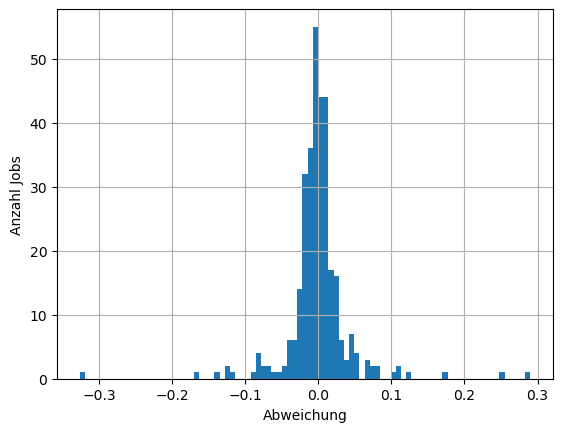

In [16]:
relative_abweichung =  (df_times["Deadline"] - df_times["Deadline_original"]) / df_times["Deadline_original"]
plt.hist(relative_abweichung , bins="auto")
plt.xlabel("Abweichung")
plt.ylabel("Anzahl Jobs")
plt.grid(True)
plt.show()

#### Export

In [18]:
df_jssp.to_csv('data/09_jssp_for_17_days.csv', index=False)

In [19]:
df_times = df_times[['Job', 'Arrival', 'Deadline']]
df_times.to_csv('data/09_times_scattered_deadlines_for_17_days.csv', index=False)

## B) Dreiecksverteilung

In [21]:
df_times = df_times_all.copy()
df_times

,Job,Arrival,Deadline_original,Processing Time
0,Job_000,0.00,1176,395
1,Job_001,82.55,1600,510
2,Job_002,143.24,1834,568
3,Job_003,194.98,2144,655
4,Job_004,231.20,1401,393
...,...,...,...,...
318,Job_318,24156.49,26106,655
319,Job_319,24162.49,25332,393
320,Job_320,24163.83,25854,568
321,Job_321,24281.32,25457,395


In [22]:
np.random.seed(45)

df_times["Deadline"] = df_times.apply(
    lambda row: np.random.triangular(
        left=row["Arrival"] + row["Processing Time"],   # frühestmögliches Ende
        mode=row["Deadline_original"],                  # Peak der Verteilung
        right=2 * row["Deadline_original"] - (row["Arrival"] + row["Processing Time"])  # symmetrisches Maximum
    ),
    axis=1
)

# Aufrunden auf nächsten ganzzahligen Wert
df_times["Deadline"] = np.ceil(df_times["Deadline"])

In [23]:
# Streuwert
df_times["Abweichung"] = df_times["Deadline"] - df_times["Deadline_original"]
min_abw = df_times["Abweichung"].min()
max_abw = df_times["Abweichung"].max()
mean_abw = df_times["Abweichung"].mean()

print(f"Minimale Abweichung: {min_abw:.2f}")
print(f"Maximale Abweichung: {max_abw:.2f}")
print(f"Mittlere Abweichung: {mean_abw:.2f}")

Minimale Abweichung: -934.00
Maximale Abweichung: 1119.00
Mittlere Abweichung: 22.35


In [24]:
df_times.sort_values(by="Abweichung", ascending=True).head(15)

,Job,Arrival,Deadline_original,Processing Time,Deadline,Abweichung
293,Job_293,22301.31,24078,597,23144.0,-934.0
261,Job_261,19836.49,21786,655,20923.0,-863.0
235,Job_235,17763.42,19367,539,18530.0,-837.0
78,Job_078,5903.24,7594,568,6787.0,-807.0
278,Job_278,21100.87,22619,510,21819.0,-800.0
254,Job_254,19203.42,20807,539,20010.0,-797.0
306,Job_306,23183.24,24874,568,24086.0,-788.0
3,Job_003,194.98,2144,655,1359.0,-785.0
109,Job_109,8316.49,10266,655,9486.0,-780.0
288,Job_288,21794.98,23744,655,22988.0,-756.0


In [25]:
df_times.sort_values(by="Abweichung", ascending=False).head(15)

,Job,Arrival,Deadline_original,Processing Time,Deadline,Abweichung
71,Job_071,5436.49,7386,655,8505.0,1119.0
225,Job_225,16963.83,18654,568,19697.0,1043.0
185,Job_185,14076.49,16026,655,17055.0,1029.0
242,Job_242,18396.49,20346,655,21360.0,1014.0
106,Job_106,8085.69,9862,597,10875.0,1013.0
84,Job_084,6461.31,8238,597,9235.0,997.0
174,Job_174,13154.98,15104,655,16094.0,990.0
197,Job_197,14883.42,16487,539,17409.0,922.0
180,Job_180,13693.09,15300,540,16186.0,886.0
56,Job_056,4220.30,5827,540,6704.0,877.0


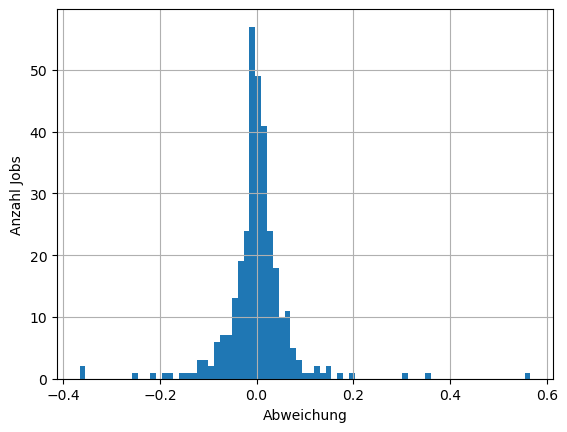

In [26]:
relative_abweichung =  (df_times["Deadline"] - df_times["Deadline_original"]) / df_times["Deadline_original"]
plt.hist(relative_abweichung , bins="auto")
plt.xlabel("Abweichung")
plt.ylabel("Anzahl Jobs")
plt.grid(True)
plt.show()